In [472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, normalize
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from scipy.stats import boxcox
import sklearn.metrics as metrics
from statsmodels.stats.diagnostic import het_breuschpagan
plt.rcParams["figure.figsize"] = [18,10]
sns.set_style("whitegrid")
sns.set_context("poster")

In [473]:
#Let's remember our final dataset
df = pd.read_csv('final_data.csv').drop(['Unnamed: 0', 'Team'], axis=1)
df.head()

,Player,Position,Age,Years,Game,GS,Minutes,FG,3P,2P,FT,DRB,Rebound,Assist,STL,BLK,TOV,PF,Point,salary
0,Steven Adams,C,25.0,6.0,80.0,80.0,33.4,6.0,0.0,6.0,1.8,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9,24157303
1,Bam Adebayo,C,21.0,2.0,82.0,28.0,23.3,3.4,0.0,3.4,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9,2955840
2,LaMarcus Aldridge,C,33.0,13.0,81.0,81.0,33.2,8.4,0.1,8.3,4.3,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3,22347015
3,Grayson Allen,SG,23.0,1.0,38.0,2.0,10.9,1.8,0.8,0.9,1.2,0.5,0.6,0.7,0.2,0.2,0.9,1.2,5.6,2074320
4,Jarrett Allen,C,20.0,2.0,80.0,80.0,26.2,4.2,0.1,4.1,2.5,6.0,8.4,1.4,0.5,1.5,1.3,2.3,10.9,2034120


In [474]:
# Recalling what each feature means
feature_names = pd.read_csv('data/feature_names.csv').drop('Unnamed: 0', axis =1)
feature_names

,Abbreviation,Meaning
0,Player,Name
1,Pos,Position
2,Game,Games Played
3,GS,Games Started
4,FG,Field Goals Made
5,3P,3 Pointers Made
6,FT,Free Throws Made
7,DRB,Defensive Rebounds
8,TRB,Total Rebounds
9,Assist,Assists Per Game


In [475]:
target = df['salary'] #our target variable is the salary, dependent variable

In [476]:
features = df.drop(['salary'], axis=1) # our features, independent variables

In [477]:
features.columns

Index(['Player', 'Position', 'Age', 'Years', 'Game', 'GS', 'Minutes', 'FG',
       '3P', '2P', 'FT', 'DRB', 'Rebound', 'Assist', 'STL', 'BLK', 'TOV', 'PF',
       'Point'],
      dtype='object')

In [478]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    337 non-null    object 
 1   Position  337 non-null    object 
 2   Age       337 non-null    float64
 3   Years     337 non-null    float64
 4   Game      337 non-null    float64
 5   GS        337 non-null    float64
 6   Minutes   337 non-null    float64
 7   FG        337 non-null    float64
 8   3P        337 non-null    float64
 9   2P        337 non-null    float64
 10  FT        337 non-null    float64
 11  DRB       337 non-null    float64
 12  Rebound   337 non-null    float64
 13  Assist    337 non-null    float64
 14  STL       337 non-null    float64
 15  BLK       337 non-null    float64
 16  TOV       337 non-null    float64
 17  PF        337 non-null    float64
 18  Point     337 non-null    float64
dtypes: float64(17), object(2)
memory usage: 50.1+ KB


As I decided during 'EDA' of this project, Points, Defensive Rebound, Field Goal Made, Minutes Played, Free Throw Made and Minutes per Game were the 5 most correlative features with salary, so I will slice the 'features' dataframe for these five only.

In [479]:
features_selected = features[['Point', 'Rebound', 'Assist', 'TOV', 'Minutes']]
features_selected.head()

,Point,Rebound,Assist,TOV,Minutes
0,13.9,9.5,1.6,1.7,33.4
1,8.9,7.3,2.2,1.5,23.3
2,21.3,9.2,2.4,1.8,33.2
3,5.6,0.6,0.7,0.9,10.9
4,10.9,8.4,1.4,1.3,26.2


In [480]:
#df['log_salary'] = np.log(df['salary'])
#df.log_salary.head()

### Using an Ordinary Least Squares Fit as the regression with only 1 variable, points

In [481]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [482]:
# Trying regression with most correlated variable, points
point = ols('Q("salary") ~ Q("Point")', df).fit()

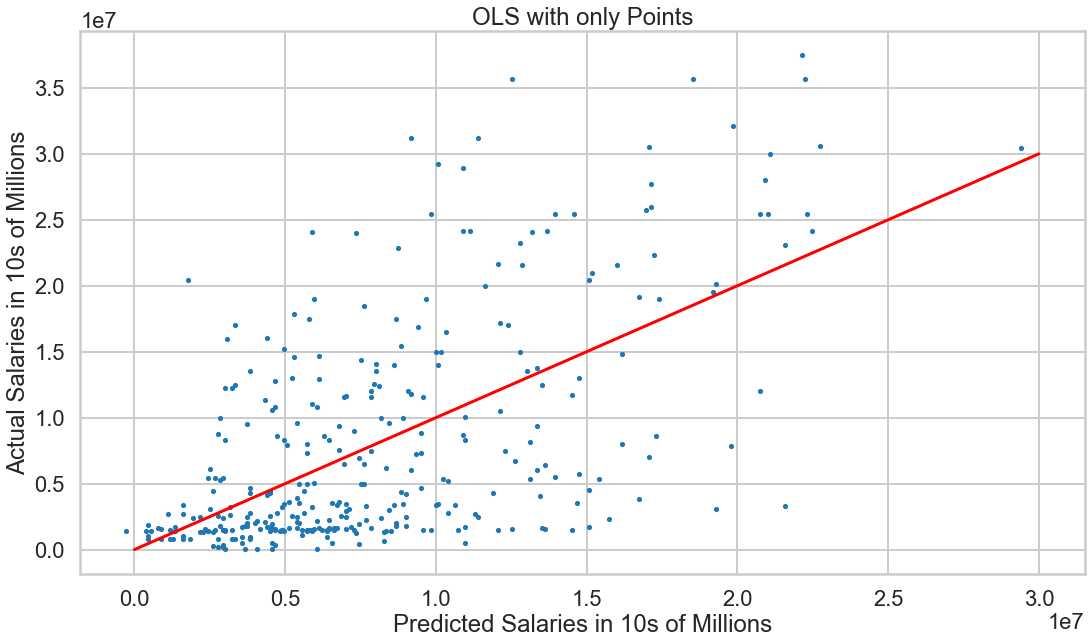

In [483]:
_ = plt.scatter(point.fittedvalues, target, s = 10)
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')
_ = plt.title('OLS with only Points')
_ = plt.plot([0,3e7],[0,3e7], color = 'r')

We have negative predicted salaries. To fix this, we will use log10 salary.

In [484]:
MSE = metrics.mean_squared_error(target, point.fittedvalues)
MSE

45648395270683.375

In [485]:
point.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("salary")   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     199.2
Date:                Mon, 11 May 2020   Prob (F-statistic):           7.94e-36
Time:                        02:38:03   Log-Likelihood:                -5777.8
No. Observations:                 337   AIC:                         1.156e+04
Df Residuals:                     335   BIC:                         1.157e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.852e+05   6.92e+05     -0.412      0.681   -1.65e+06    1.08e+06
Q("Point")   8.22e+05   5.82e+04     14.115      0.000    7.07e+05    9.37e+05
==============================================================================
Omnibus:                       29.435   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.364
Skew:                           0.706   Prob(JB):                     2.09e-08
Kurtosis:                       3.726   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see, the Mean-Squared Error is very high at 45$\times$ $10^{12}$ and the $R^2$ value is pretty low at 0.373. Eventhough this is very low, it is still good regading that only 1 feature can predict 37% of the variance in the salary.

### Trying OLS with 3 important variables, Point, Rebound, Assist

In [486]:
three_variable = ols('Q("salary") ~ Q("Point") + Rebound + Assist',df).fit()

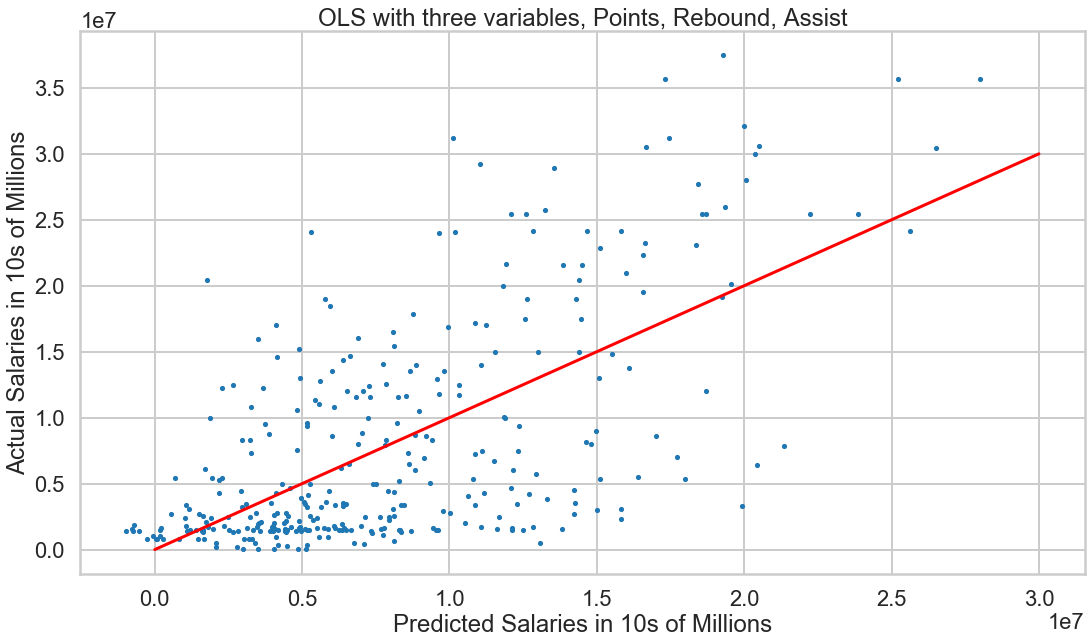

In [487]:
_ = plt.scatter(three_variable.fittedvalues, target, s = 10)
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')
_ = plt.title('OLS with three variables, Points, Rebound, Assist')
_ = plt.plot([0,3e7],[0,3e7], color = 'r')

In [488]:
MSE2 = metrics.mean_squared_error(target, three_variable.fittedvalues)
MSE2

41744740764147.8

In [489]:
three_variable.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("salary")   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     82.57
Date:                Mon, 11 May 2020   Prob (F-statistic):           5.86e-40
Time:                        02:38:03   Log-Likelihood:                -5762.8
No. Observations:                 337   AIC:                         1.153e+04
Df Residuals:                     333   BIC:                         1.155e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.808e+06   7.34e+05     -2.464      0.014   -3.25e+06   -3.65e+05
Q("Point")  4.137e+05   9.22e+04      4.487      0.000    2.32e+05    5.95e+05
Rebound     7.455e+05   1.73e+05      4.314      0.000    4.06e+05    1.09e+06
Assist      1.126e+06   2.57e+05      4.388      0.000    6.21e+05    1.63e+06
==============================================================================
Omnibus:                       15.517   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.400
Skew:                           0.502   Prob(JB):                     0.000275
Kurtosis:                       3.401   Cond. No.                         27.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By using an OLS with 3 varibles instead of 1, the $R^2$ value increase by 0.05. However it is still not good. Other thing to note is that the Skew and the Kurtosis on this second OLS have decreased. The lower kurtosis value means that it is less leptokurtic, resulting in less outliers, this is good news. However, the Skewness should have been higher than this. The F-statistic also drastically decreased by about one third from 200 to 82. High F-statistics means that this model can be considered as statistically significant.

### Trying OLS with 5 important variables I have decided during EDA, Point, Assist, Rebound , Assist, Field Goal, Turnover

In [516]:
all_variable = ols('Q("salary") ~ Assist + Q("Point") + Rebound + TOV',df).fit()

In [517]:
MSE_all = metrics.mean_squared_error(target, all_variable.fittedvalues)
MSE_all

41194811199277.64

In [518]:
all_variable.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("salary")   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     63.67
Date:                Mon, 11 May 2020   Prob (F-statistic):           6.54e-40
Time:                        02:44:36   Log-Likelihood:                -5760.5
No. Observations:                 337   AIC:                         1.153e+04
Df Residuals:                     332   BIC:                         1.155e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.822e+06    7.3e+05     -2.497      0.013   -3.26e+06   -3.86e+05
Assist       1.74e+06   3.88e+05      4.489      0.000    9.78e+05     2.5e+06
Q("Point")  5.424e+05    1.1e+05      4.921      0.000    3.26e+05    7.59e+05
Rebound      8.88e+05   1.85e+05      4.806      0.000    5.25e+05    1.25e+06
TOV        -2.612e+06   1.24e+06     -2.105      0.036   -5.05e+06   -1.71e+05
==============================================================================
Omnibus:                       16.178   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.123
Skew:                           0.529   Prob(JB):                     0.000191
Kurtosis:                       3.315   Cond. No.                         47.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time, Skew increased and Kurtosis decreased. This is best model for testing split. The $R^{2}$ value increased by another 0.03, and the F-statistic decreased by almost half again, but considering how large that value is, this model is still statistically significant. The p-values all remain around 0, meaning they are all significant to the model.

The largest coefficient belongs to the Assist category, at 1,740,000 meaning if all other variables held constant, increasing your assists by 1 unit, you will earn an added $1,740,000. It is the same for Point as well. This makes sense because, on average, players average a lot less assists than other stats.

It is also not surprising to see that Turnover had a negative coefficient, meaning if all other variables held constant, increasing the number of turnovers you have by 1 will decrease your salary by $2.612,470. You should not be losing a ball a lot!

Even with this model, only about 43% of the variance in the salary can be predicted with Point, Assist, Rebound , Assist, Turnover.

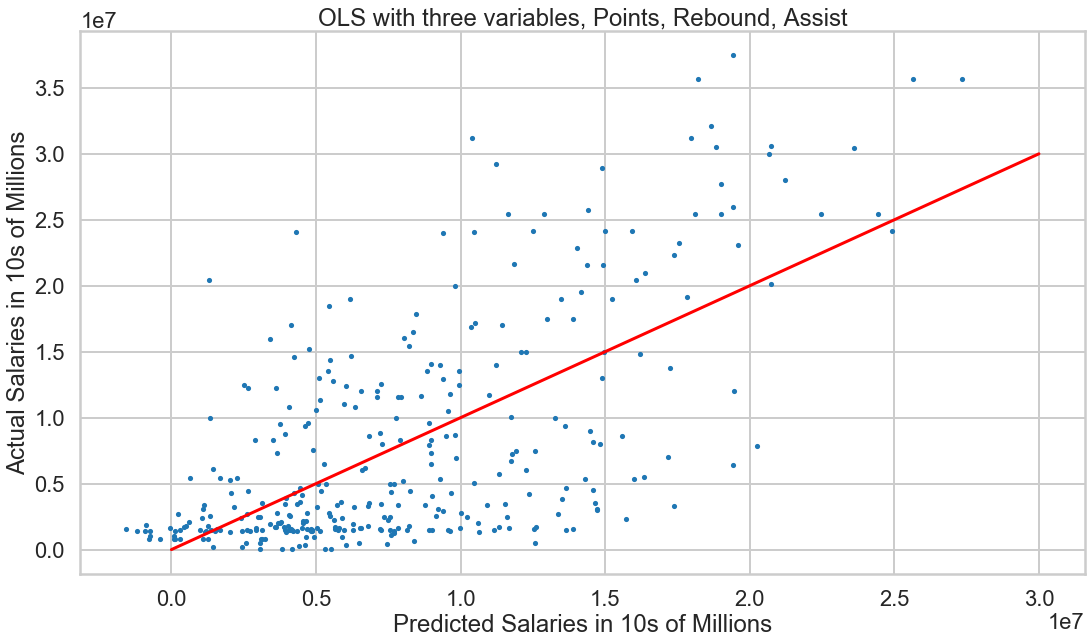

In [519]:
_ = plt.scatter(all_variable.fittedvalues, target, s = 10)
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')
_ = plt.title('OLS with three variables, Points, Rebound, Assist')
_ = plt.plot([0,3e7],[0,3e7], color = 'r')

The reason why we see accumulated predictions near 0 is because of rookie players or players who are signed minimum wage contract. They are mostly G-Leagu players who are playing a lot in the NBA.

# Doing the same OLS without rookie players included. With some additional filtering. Years > 3 will be used.

In [609]:
wo_rookie = df[df['Years'] > 3] # Excluding rookies
wo_rookie = wo_rookie[wo_rookie['Minutes'] > 10] # Selecting players who at least played 10 minutes per game
wo_rookie = wo_rookie[wo_rookie['Game'] > 20] # Selecting players who played at least quarter of the season
wo_rookie = wo_rookie[wo_rookie['salary'] > 1350000] # Selecting players who are earning more than minimum wage
wo_rookie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 334
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    190 non-null    object 
 1   Position  190 non-null    object 
 2   Age       190 non-null    float64
 3   Years     190 non-null    float64
 4   Game      190 non-null    float64
 5   GS        190 non-null    float64
 6   Minutes   190 non-null    float64
 7   FG        190 non-null    float64
 8   3P        190 non-null    float64
 9   2P        190 non-null    float64
 10  FT        190 non-null    float64
 11  DRB       190 non-null    float64
 12  Rebound   190 non-null    float64
 13  Assist    190 non-null    float64
 14  STL       190 non-null    float64
 15  BLK       190 non-null    float64
 16  TOV       190 non-null    float64
 17  PF        190 non-null    float64
 18  Point     190 non-null    float64
 19  salary    190 non-null    int64  
dtypes: float64(17), int64(1), object

In [593]:
target_wo_rookie = wo_rookie['salary'] #our target variable is the salary, dependent variable

In [594]:
features_wo_rookie = wo_rookie.drop('salary', axis=1)
features_wo_rookie.columns

Index(['Player', 'Position', 'Age', 'Years', 'Game', 'GS', 'Minutes', 'FG',
       '3P', '2P', 'FT', 'DRB', 'Rebound', 'Assist', 'STL', 'BLK', 'TOV', 'PF',
       'Point'],
      dtype='object')

### Using an Ordinary Least Squares Fit as the regression with only 1 variable, points

In [595]:
# Trying regression with most correlated variable, points
point_wo_rookie = ols('Q("salary") ~ Q("Point")', wo_rookie).fit()

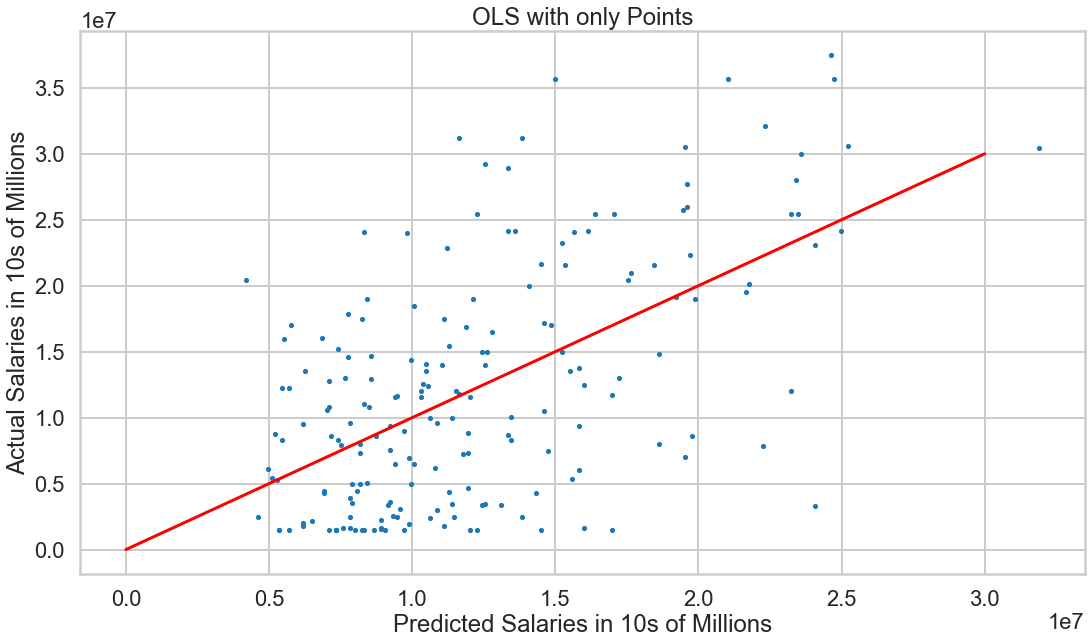

In [596]:
_ = plt.scatter(point_wo_rookie.fittedvalues, target_wo_rookie, s = 10)
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')
_ = plt.title('OLS with only Points')
_ = plt.plot([0,3e7],[0,3e7], color = 'r')

We have negative predicted salaries. To fix this, we will use log10 salary.

In [597]:
MSE = metrics.mean_squared_error(target_wo_rookie, point_wo_rookie.fittedvalues)
MSE

55134843106830.82

In [598]:
point_wo_rookie.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("salary")   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     94.92
Date:                Mon, 11 May 2020   Prob (F-statistic):           2.05e-18
Time:                        03:07:42   Log-Likelihood:                -3275.5
No. Observations:                 190   AIC:                             6555.
Df Residuals:                     188   BIC:                             6561.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.148e+06   1.16e+06      1.849      0.066   -1.43e+05    4.44e+06
Q("Point")   8.24e+05   8.46e+04      9.742      0.000    6.57e+05    9.91e+05
==============================================================================
Omnibus:                        2.904   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.916
Skew:                           0.297   Prob(JB):                        0.233
Kurtosis:                       2.871   Cond. No.                         29.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see, the Mean-Squared Error is very high at 55$\times$ $10^{12}$ and the $R^2$ value is pretty low at 0.353. Eventhough this is very low, it is still good regading that only 1 feature can predict 35% of the variance in the salary.

### Trying OLS with 3 important variables, Point, Rebound, Assist

In [599]:
three_variable_wo_rookie = ols('Q("salary") ~ Q("Point") + Rebound + Assist',wo_rookie).fit()

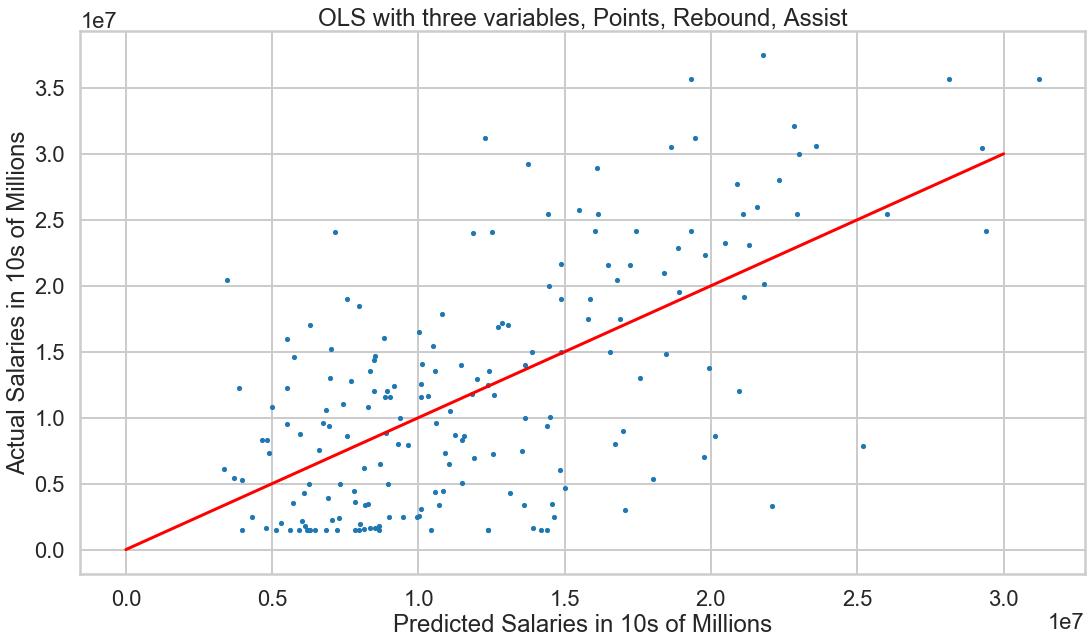

In [600]:
_ = plt.scatter(three_variable_wo_rookie.fittedvalues, target_wo_rookie, s = 10)
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')
_ = plt.title('OLS with three variables, Points, Rebound, Assist')
_ = plt.plot([0,3e7],[0,3e7], color = 'r')

In [601]:
MSE2 = metrics.mean_squared_error(target_wo_rookie, three_variable_wo_rookie.fittedvalues)
MSE2

48932287911351.22

In [602]:
three_variable_wo_rookie.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("salary")   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     43.13
Date:                Mon, 11 May 2020   Prob (F-statistic):           3.32e-21
Time:                        03:07:42   Log-Likelihood:                -3264.1
No. Observations:                 190   AIC:                             6536.
Df Residuals:                     186   BIC:                             6549.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.326e+05   1.24e+06     -0.429      0.669   -2.98e+06    1.92e+06
Q("Point")  4.314e+05   1.16e+05      3.707      0.000    2.02e+05    6.61e+05
Rebound     9.294e+05   2.23e+05      4.170      0.000     4.9e+05    1.37e+06
Assist      1.079e+06   3.25e+05      3.323      0.001    4.38e+05    1.72e+06
==============================================================================
Omnibus:                        0.585   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.747   Jarque-Bera (JB):                0.629
Skew:                           0.131   Prob(JB):                        0.730
Kurtosis:                       2.896   Cond. No.                         36.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By using an OLS with 3 varibles instead of 1, the $R^2$ value increase by 0.07. However it is still not good. Other thing to note is that the Skew and the Kurtosis on this second OLS have decreased. The lower kurtosis value means that it is less leptokurtic, resulting in less outliers, this is good news. However, the Skewness should have been higher than this. The F-statistic also drastically decreased by about one third from 109 to 47. High F-statistics means that this model can be considered as statistically significant.

### Trying OLS with 5 important variables I have decided during EDA, Point, Assist, Rebound , Assist,  Game started

In [603]:
all_variable_wo_rookie = ols('Q("salary") ~ Assist + Q("Point") + Rebound + GS' ,wo_rookie).fit()

In [604]:
MSE_all = metrics.mean_squared_error(target_wo_rookie, all_variable_wo_rookie.fittedvalues)
MSE_all

47705644394591.06

In [605]:
all_variable_wo_rookie.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("salary")   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     34.19
Date:                Mon, 11 May 2020   Prob (F-statistic):           2.36e-21
Time:                        03:07:42   Log-Likelihood:                -3261.7
No. Observations:                 190   AIC:                             6533.
Df Residuals:                     185   BIC:                             6550.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.412e+05   1.24e+06     -0.114      0.910   -2.59e+06    2.31e+06
Assist       9.81e+05   3.25e+05      3.022      0.003    3.41e+05    1.62e+06
Q("Point")   3.36e+05   1.23e+05      2.726      0.007    9.28e+04    5.79e+05
Rebound     7.396e+05   2.37e+05      3.118      0.002    2.72e+05    1.21e+06
GS          5.158e+04   2.36e+04      2.181      0.030    4922.746    9.82e+04
==============================================================================
Omnibus:                        0.834   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.791
Skew:                           0.156   Prob(JB):                        0.673
Kurtosis:                       2.954   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time, Skew increased and Kurtosis decreased. This is best model for testing split. The $R^{2}$ value increased by another 0.035, and the F-statistic decreased by 10 again, but considering how large that value is, this model is still statistically significant. The p-values all remain around 0, meaning they are all significant to the model.

The largest coefficient belongs to the Assist category again, at 981,000 meaning if all other variables held constant, increasing your assists by 1 unit, you will earn an added $980,000. It is the same for Point as well. This makes sense because, on average, players average a lot less assists than other stats.

Even with this model, only about 43% of the variance in the salary can be predicted with Point, Assist, Rebound , Assist, Turnover.

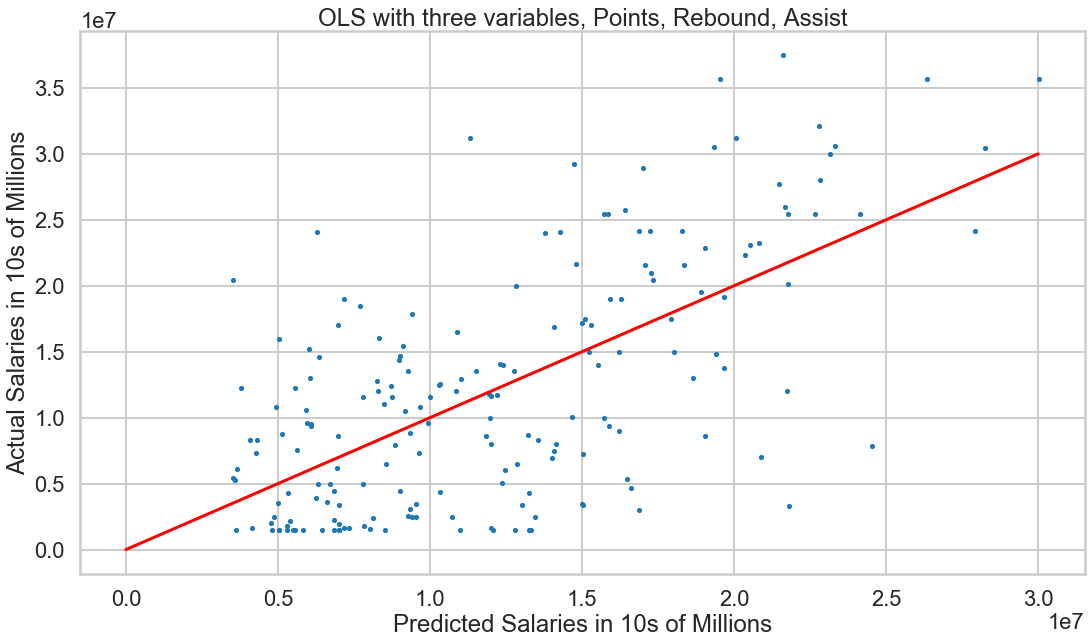

In [606]:
_ = plt.scatter(all_variable_wo_rookie.fittedvalues, target_wo_rookie, s = 10)
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')
_ = plt.title('OLS with three variables, Points, Rebound, Assist')
_ = plt.plot([0,3e7],[0,3e7], color = 'r')

## Models

In [610]:
shuffled = df.sample(frac = 1, random_state =5)

In [614]:
X_train, X_test, y_train, y_test = train_test_split(shuffled[['TOV','Rebound','Assist','Point']],
                                                    shuffled['salary'], test_size=0.2, random_state=42)

In [615]:
x_train = sm.add_constant(X_train) #adding the intercept


In [616]:
model = sm.OLS(y_train, X_train)

In [617]:
results = model.fit()

In [620]:
predictions = results.predict(X_test)

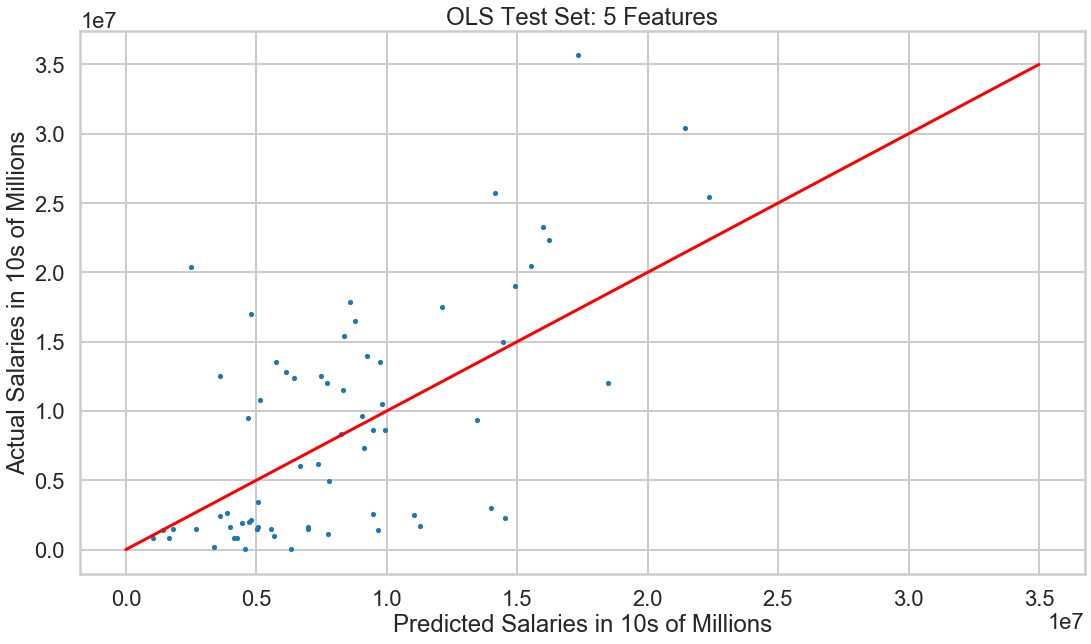

In [621]:
_ = plt.scatter(predictions, y_test, s = 10)
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')
_ = plt.title('OLS Test Set: 5 Features')
_ = plt.plot([0,3.5e7],[0,3.5e7], color = 'r')

In [622]:
np.corrcoef(y_test, predictions)[0,1]**2

0.44331307816792753

In [623]:
MSEtts = metrics.mean_squared_error(y_test, predictions)
MSEtts

39503281942105.805

Using the same OLS but with a train and test split, I get an $R^2$ value of 0.44, which is higher than OLS. I also get a mean squared error of $39 \times 10^{12}$. This means that 44% of the testing set's variance in salary was predicted using these 4 features, also the mean squared error decreased. Improved.

## Using a Linear Regression model with the 4 features used in last OLS

In [625]:
X = shuffled[['TOV','Rebound','Assist','Point']] 
target2 = shuffled['salary']

In [624]:
reg = LinearRegression()

In [627]:
X_train, X_test, y_train, y_test = train_test_split(X, target2, test_size = 0.2, random_state = 42)

In [628]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [629]:
y_pred = reg.predict(X_test).reshape(-1,1)

In [630]:
reg.score(X_test, y_test)

0.427879100343159

In [631]:
MSE_reg = metrics.mean_squared_error(y_pred, y_test)
MSE_reg

39693671101934.81

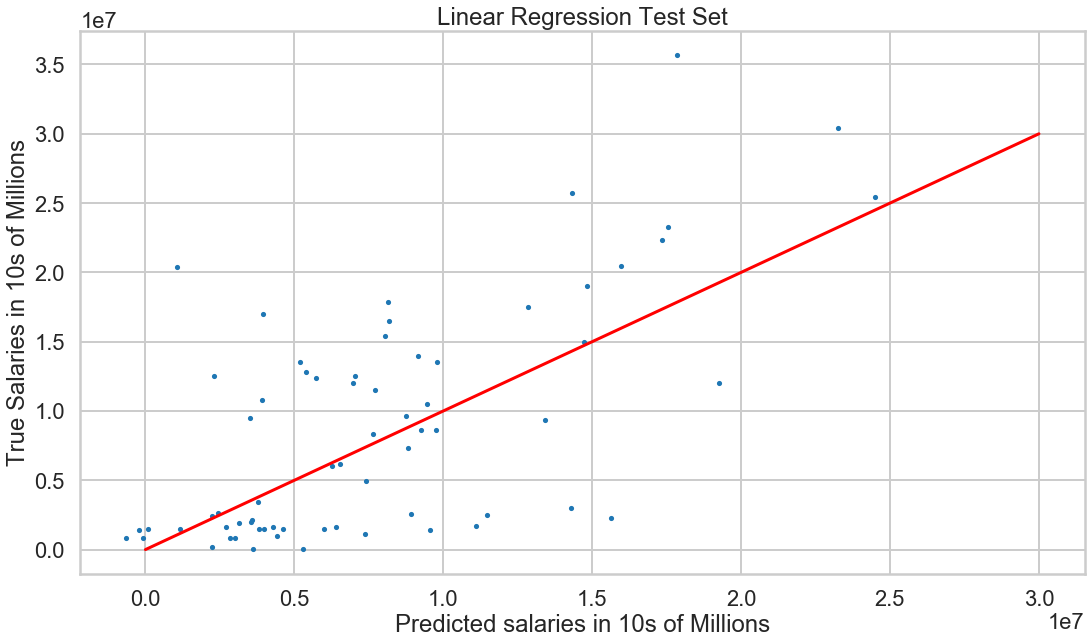

In [632]:
_ = plt.scatter(y_pred, y_test, s = 10)
_ = plt.xlabel('Predicted salaries in 10s of Millions')
_ = plt.ylabel('True Salaries in 10s of Millions')
_ = plt.title('Linear Regression Test Set')
_ = plt.plot([0,3e7],[0,3e7], color = 'r')

In [665]:
cv_results = cross_val_score(reg, X, target2, cv = 5)
cv_results.mean()

0.3592634869956819

The results are scored with a $R^2$ metric, which is between 0 (for lowest correlation) and 1 (highest correlation), so this model is at least somewhat effective at predicting the salaries of the player with %0.35.

### Going to try Lasso Regression and Cross Validate for different Meta-Parameters


In [644]:
X_las = shuffled.drop(['salary', 'Position','Player','Years'], axis = 1)
y_las = shuffled['salary']

In [645]:
alphas = [0.001,0.1, 1, 10, 50, 100, 1000]

In [647]:
from sklearn.linear_model import Lasso

results = []
for alpha in alphas:
    lasso = Lasso(alpha = alpha, tol = 0.5)
    lasso_cv = cross_val_score(lasso, X_las, y_las, cv= 10)
    print(lasso_cv.mean(), alpha)

0.3574652095323788 0.001
0.3574652208958332 0.1
0.35746532419976157 1
0.35746635721914916 10
0.3574709479787398 50
0.3574766854233324 100
0.3575797684958637 1000


Since my dataset is not that big, the score with the different alphas does not differ that much. The score does seem to get a little bit better when $\alpha$ increases, so in the following model, I will choose $\alpha = 1000$. Lasso Regression is typically used for very large matrices, somtimes up to thousands of features. So it makes sense that optimizing the regression does not change the results very significantly.

In [683]:
lasso_best = Lasso(alpha = 1000, tol = 0.5)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_las, y_las, test_size = 0.2, random_state = 42)
lasso_best.fit(Xl_train, yl_train)
y_pred_lasso = lasso_best.predict(Xl_test)

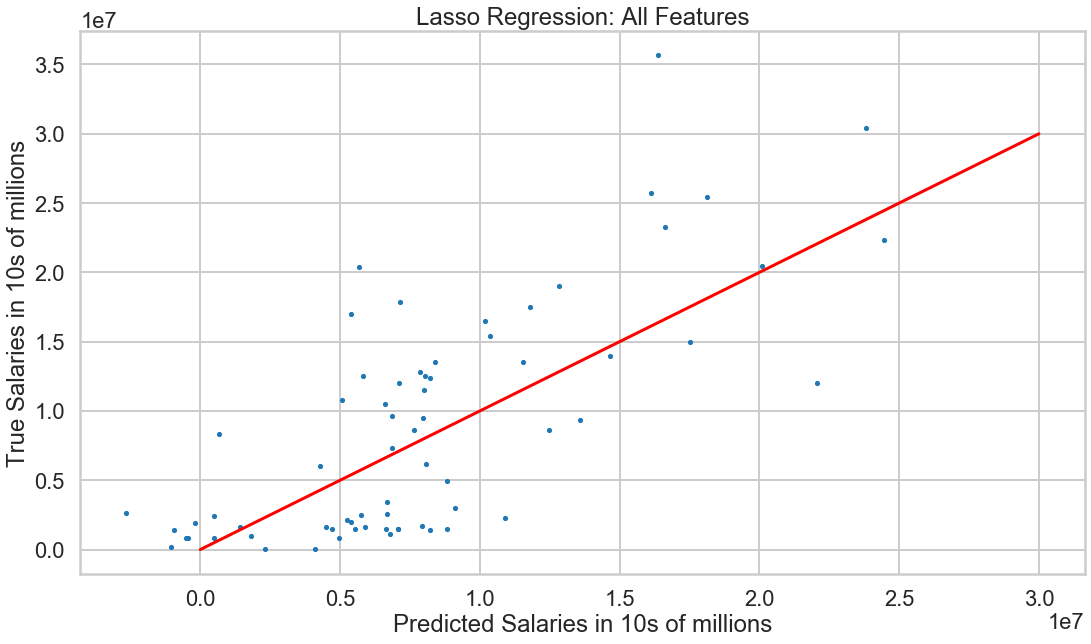

In [684]:
_ = plt.scatter(y_pred_lasso, yl_test, s = 10)
_ = plt.plot([0,3e7],[0,3e7], color = 'r')
_ = plt.xlabel('Predicted Salaries in 10s of millions')
_ = plt.ylabel('True Salaries in 10s of millions')
_ = plt.title('Lasso Regression: All Features')

In [685]:
lasso_best.score(Xl_test,yl_test)

0.5261209031886639

In [686]:
results_lasso = cross_val_score(lasso_best, X_las, y_las, cv= 10)
results_lasso.mean()

0.3575797684958637

In [687]:
MSE_lasso = metrics.mean_squared_error(y_pred_lasso, yl_test)
MSE_lasso

32877668028197.13

#### Lasso Regression has improved the score to 0.526 (0.357 from Cross-Validation), which was down from 0.359, but reduced the MSE to about $32 \times 10^{12}$, which is still very high, but lower than $39 \times 10^{12}$, which is what I got from the normal Linear Regression.

There are a few point that were predicted as negative. The reason is because minimum wage has to be paid even if player does not deserve that amount. As we saw in the histograms and scatter plots, salaries had a hard floor because of this.

### Using a Ridge Regression model¶

In [693]:
from sklearn.linear_model import Ridge

results = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha, tol = 0.5)
    ridge_cv = cross_val_score(ridge, X_las, y_las, cv= 5)
    print(ridge_cv.mean(), alpha)

0.43349023704061834 0.001
0.4373321445753052 0.1
0.4413497823780134 1
0.4461578642142263 10
0.4478833546277784 50
0.44670800582250364 100
0.43689743886681587 1000


In ridge reression, $\alpha$ actually makes a bit of a difference, going from 0.433 to 0.447. Still not much.

In [691]:
ridge_best = Ridge(alpha = 50, tol = 0.5)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_las, y_las, test_size = 0.2, random_state = 42)
ridge_best.fit(Xr_train, yr_train)
y_pred_ridge = ridge_best.predict(Xr_test)

In [692]:
ridge_best.score(Xr_test, yr_test)

0.5356929028753887

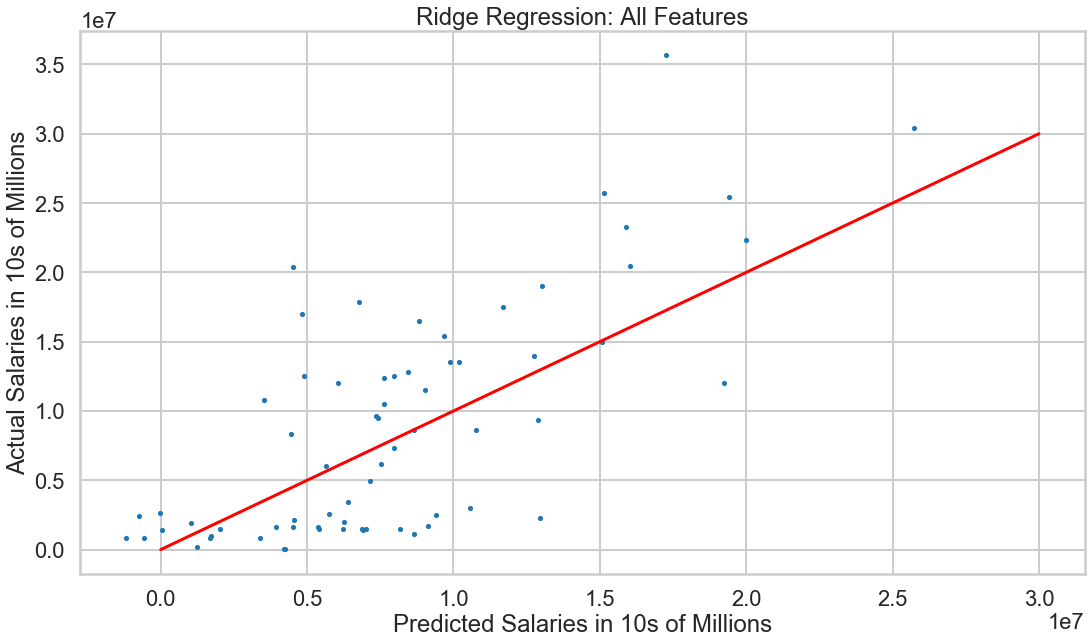

In [680]:
_ = plt.scatter(y_pred_ridge, yr_test, s = 10)
_ = plt.plot([0, 3e7],[0,3e7], color = 'r')
_ = plt.title('Ridge Regression: All Features')
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')

In [694]:
ridge_score = cross_val_score(ridge_best, X_las, y_las, cv= 5)
ridge_score.mean()

0.4478833546277784

In [695]:
MSE_ridge = metrics.mean_squared_error(y_pred_ridge, yr_test)
MSE_ridge

32213563976797.203

Ridge regression yielded a better performing model, but not by much. The score from cross validation was about 0.45 in this regression. The MSE is also still around $32 \times 10^{12}$.
From these regressions, you can tell that these regressions are all peaking at explaining about 50% of the variance in salary, but changing and optimizing them does not seem to help me in predicting the players' salaries. The best model after using a train and test set was the Ridge Regression with all variables besides the categorical ones, which resulted in an $R^2$ of 0.535, and a MSE of $32 \times 10^{12}$

Now I am going to try the Ridge Regression again with filtered dataset without Rookie players.

# Using the same models with wo_rookie dataset. Excluding rookie players and players who did not play enough.

In [697]:
shuffled1 = wo_rookie.sample(frac = 1, random_state =5)

In [698]:
X_train, X_test, y_train, y_test = train_test_split(shuffled1[['GS','Rebound','Assist','Point']],
                                                    shuffled1['salary'], test_size=0.2, random_state=42)

In [699]:
x_train = sm.add_constant(X_train) #adding the intercept


In [700]:
model = sm.OLS(y_train, X_train)

In [701]:
results = model.fit()

In [702]:
predictions = results.predict(X_test)

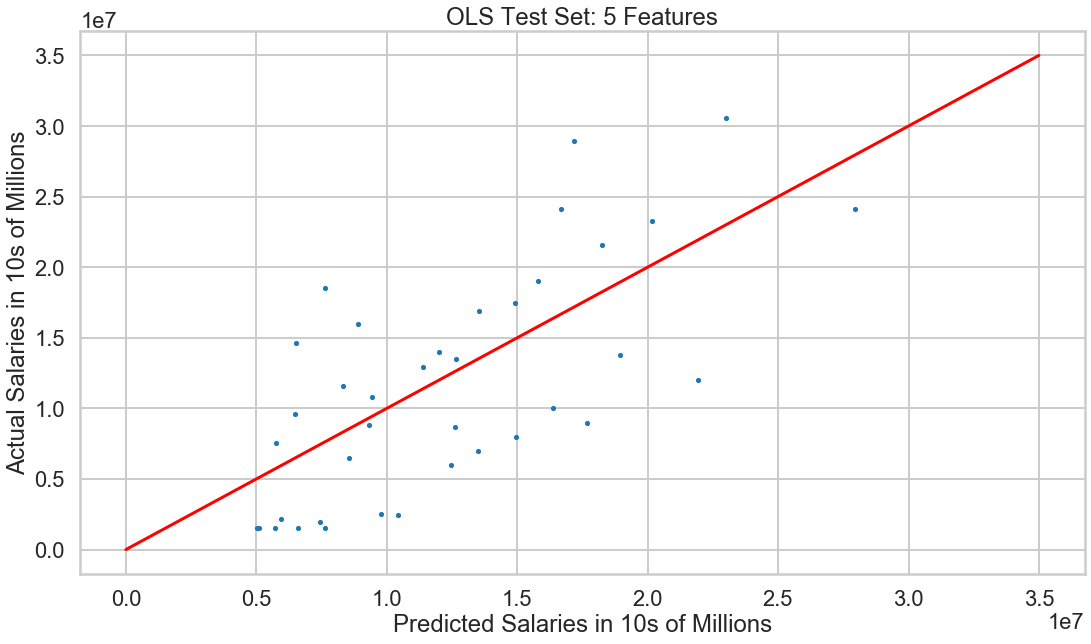

In [703]:
_ = plt.scatter(predictions, y_test, s = 10)
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')
_ = plt.title('OLS Test Set: 5 Features')
_ = plt.plot([0,3.5e7],[0,3.5e7], color = 'r')

In [704]:
np.corrcoef(y_test, predictions)[0,1]**2

0.49277107241135076

In [705]:
MSEtts = metrics.mean_squared_error(y_test, predictions)
MSEtts

32674932153501.605

Using the same OLS but with a train and test split, I get an $R^2$ value of 0.49, which is much higher than OLS(0.42). I also get a mean squared error of $32 \times 10^{12}$. This means that 49% of the testing set's variance in salary was predicted using these 4 features, also the mean squared error decreased a lot but still around 30's. Improved.

## Using a Linear Regression model with the 4 features used in last OLS

In [706]:
X = shuffled1[['GS','Rebound','Assist','Point']] 
target2 = shuffled1['salary']

In [707]:
reg = LinearRegression()

In [708]:
X_train, X_test, y_train, y_test = train_test_split(X, target2, test_size = 0.2, random_state = 42)

In [709]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [710]:
y_pred = reg.predict(X_test).reshape(-1,1)

In [711]:
reg.score(X_test, y_test)

0.48508505402053925

In [712]:
MSE_reg = metrics.mean_squared_error(y_pred, y_test)
MSE_reg

32723083760583.54

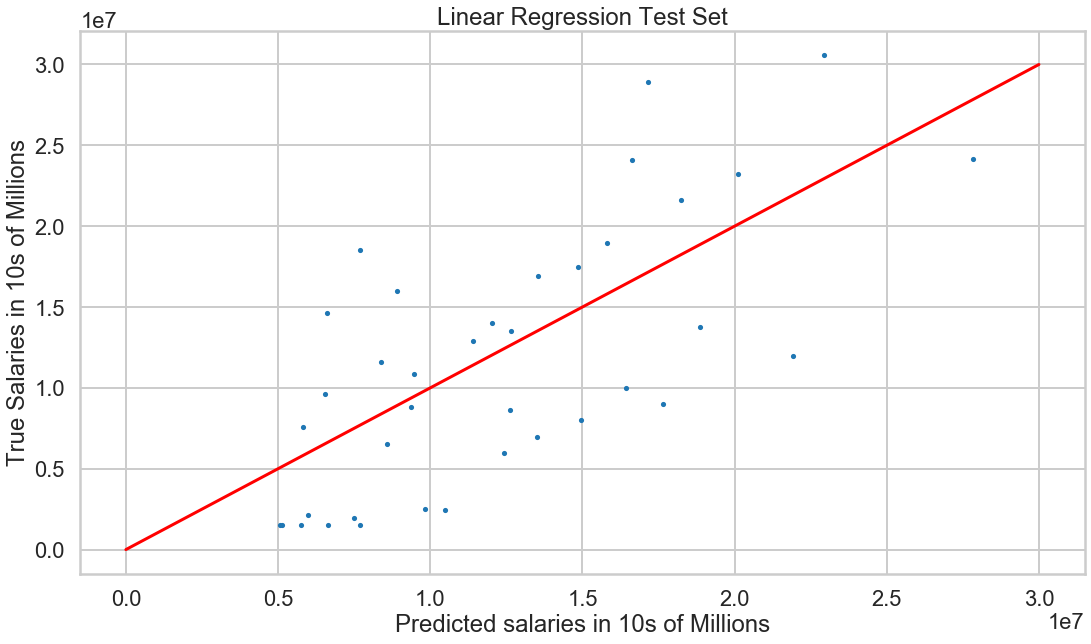

In [713]:
_ = plt.scatter(y_pred, y_test, s = 10)
_ = plt.xlabel('Predicted salaries in 10s of Millions')
_ = plt.ylabel('True Salaries in 10s of Millions')
_ = plt.title('Linear Regression Test Set')
_ = plt.plot([0,3e7],[0,3e7], color = 'r')

In [714]:
cv_results = cross_val_score(reg, X, target2, cv = 5)
cv_results.mean()

0.3726056421151265

The results are scored with a $R^2$ metric, which is between 0 (for lowest correlation) and 1 (highest correlation), so this model is at least effective at predicting the salaries of the player with %0.37.

### Going to try Lasso Regression and Cross Validate for different Meta-Parameters


In [715]:
X_las = shuffled1.drop(['salary', 'Position','Player','Years'], axis = 1)
y_las = shuffled1['salary']

In [716]:
alphas = [0.001,0.1, 1, 10, 50, 100, 1000]

In [717]:
from sklearn.linear_model import Lasso

results = []
for alpha in alphas:
    lasso = Lasso(alpha = alpha, tol = 0.5)
    lasso_cv = cross_val_score(lasso, X_las, y_las, cv= 10)
    print(lasso_cv.mean(), alpha)

0.32026332944016545 0.001
0.32026334027267533 0.1
0.3202634387497946 1
0.320264423496838 10
0.32026879961911614 50
0.3202742685522629 100
0.3203705278538421 1000


Since my dataset is not that big, the score with the different alphas does not differ that much. The score does seem to get a little bit better when $\alpha$ increases, so in the following model, I will choose $\alpha = 1000$. Lasso Regression is typically used for very large matrices, somtimes up to thousands of features. So it makes sense that optimizing the regression does not change the results very significantly.

In [718]:
lasso_best = Lasso(alpha = 1000, tol = 0.5)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_las, y_las, test_size = 0.2, random_state = 42)
lasso_best.fit(Xl_train, yl_train)
y_pred_lasso = lasso_best.predict(Xl_test)

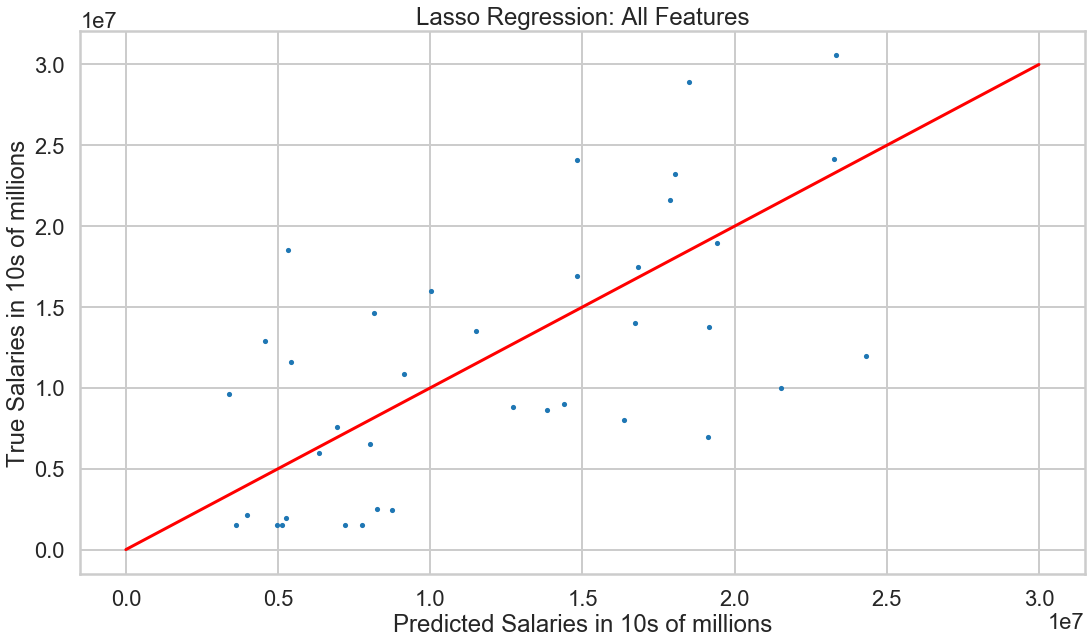

In [719]:
_ = plt.scatter(y_pred_lasso, yl_test, s = 10)
_ = plt.plot([0,3e7],[0,3e7], color = 'r')
_ = plt.xlabel('Predicted Salaries in 10s of millions')
_ = plt.ylabel('True Salaries in 10s of millions')
_ = plt.title('Lasso Regression: All Features')

In [720]:
lasso_best.score(Xl_test,yl_test)

0.37949192352654215

In [721]:
results_lasso = cross_val_score(lasso_best, X_las, y_las, cv= 10)
results_lasso.mean()

0.3203705278538421

In [722]:
MSE_lasso = metrics.mean_squared_error(y_pred_lasso, yl_test)
MSE_lasso

39433576203417.24

#### Lasso Regression has improved the score to 0.37 (0.321 from Cross-Validation), which was down from 0.3529, but increased the MSE to about $39 \times 10^{12}$, which is higher than $32 \times 10^{12}$, which is what I got from the normal Linear Regression.

### Using a Ridge Regression model¶

In [723]:
from sklearn.linear_model import Ridge

results = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha, tol = 0.5)
    ridge_cv = cross_val_score(ridge, X_las, y_las, cv= 5)
    print(ridge_cv.mean(), alpha)

0.3370450993426962 0.001
0.34661817224884894 0.1
0.35672622451041425 1
0.3766341898769657 10
0.39575124320773486 50
0.4025411682945547 100
0.40857245780795315 1000


In ridge reression, $\alpha$ actually makes a bit of a difference, going from 0.33 to 0.407. Still not much.

In [724]:
ridge_best = Ridge(alpha = 1000, tol = 0.5)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_las, y_las, test_size = 0.2, random_state = 42)
ridge_best.fit(Xr_train, yr_train)
y_pred_ridge = ridge_best.predict(Xr_test)

In [725]:
ridge_best.score(Xr_test, yr_test)

0.5825117444872814

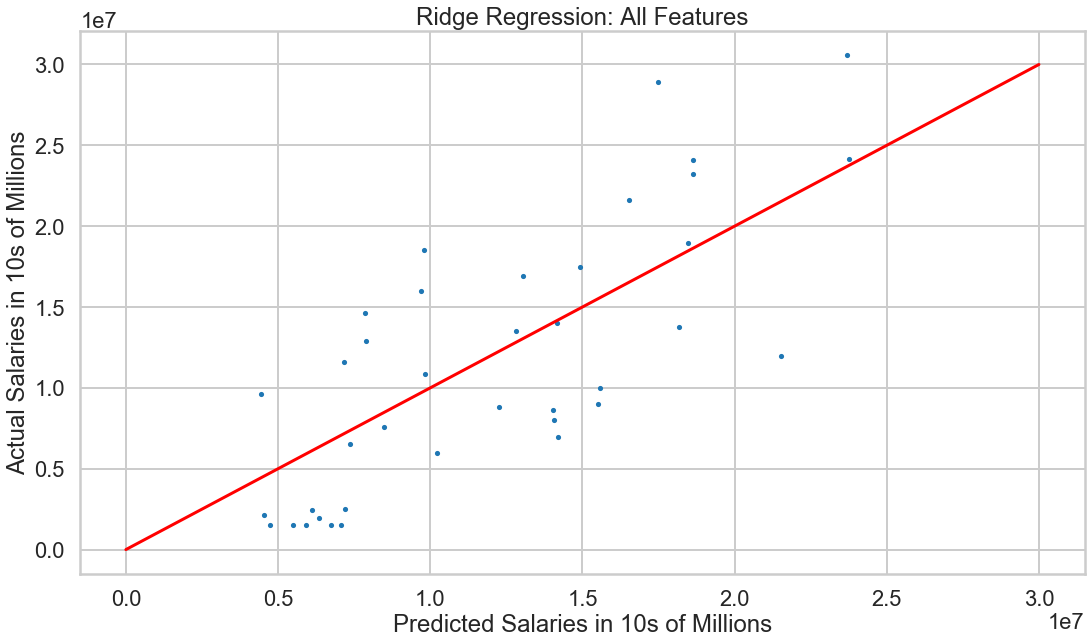

In [726]:
_ = plt.scatter(y_pred_ridge, yr_test, s = 10)
_ = plt.plot([0, 3e7],[0,3e7], color = 'r')
_ = plt.title('Ridge Regression: All Features')
_ = plt.xlabel('Predicted Salaries in 10s of Millions')
_ = plt.ylabel('Actual Salaries in 10s of Millions')

In [735]:
ridge_score = cross_val_score(ridge_best, X_las, y_las, cv= 5)
ridge_score.mean()

0.40857245780795315

In [728]:
MSE_ridge = metrics.mean_squared_error(y_pred_ridge, yr_test)
MSE_ridge

26531572371075.695

Ridge regression yielded a better performing model.Obviously, the score from cross validation was about 0.41 in this regression. The MSE is also still around $26 \times 10^{12}$.
From these regressions, you can tell that these regressions are all peaking at explaining about 58% of the variance in salary, but changing and optimizing them does not seem to help me in predicting the players' salaries. The best model after using a train and test set was the Ridge Regression with all variables besides the categorical ones, which resulted in an $R^2$ of 0.58, and a MSE of $26 \times 10^{12}$

Best result so far.